In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import cv2

In [2]:
%matplotlib inline

In [3]:
print(cv2.__version__)
print(tf.__version__)
print(np.__version__)

4.2.0
2.0.0
1.18.1


In [4]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

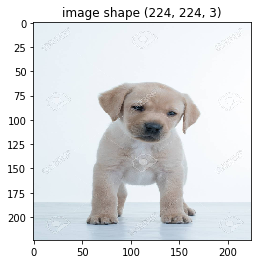

In [6]:
image = np.array(tf.keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.title("image shape {}".format(image.shape))
plt.imshow(image)
plt.show()

In [7]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [8]:
preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image.astype(np.float32))
input_image = np.expand_dims(preprocessed_image, axis=0)  # Needs to be of shape (1, 224, 244, 3)
print(input_image.shape)

(1, 224, 224, 3)


In [9]:
predictions = np.squeeze(model.predict(input_image))
prediction_index = np.argmax(predictions)
print(prediction_index)
prediction_class = labelmap[str(prediction_index)]
prediction_score = predictions[prediction_index]

print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))

208
Prediction: Labrador_retriever
Confidence score: 0.8906826972961426


# Slide a Mask along the image

In [10]:
mask_size=50
masked_images = []
for i in range(0, image.shape[0], int(mask_size/2)):
    for j in range(0, image.shape[1], int(mask_size/2)):
        masked_image = image.copy()
        masked_image[i: i + mask_size, j: j + mask_size, :] = 0
        masked_images.append(masked_image)

In [11]:
len(masked_images)

81

In [12]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(np.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images


In [13]:
image_size = (int(np.sqrt(len(masked_images))), int(np.sqrt(len(masked_images))))
print(image_size)

(9, 9)


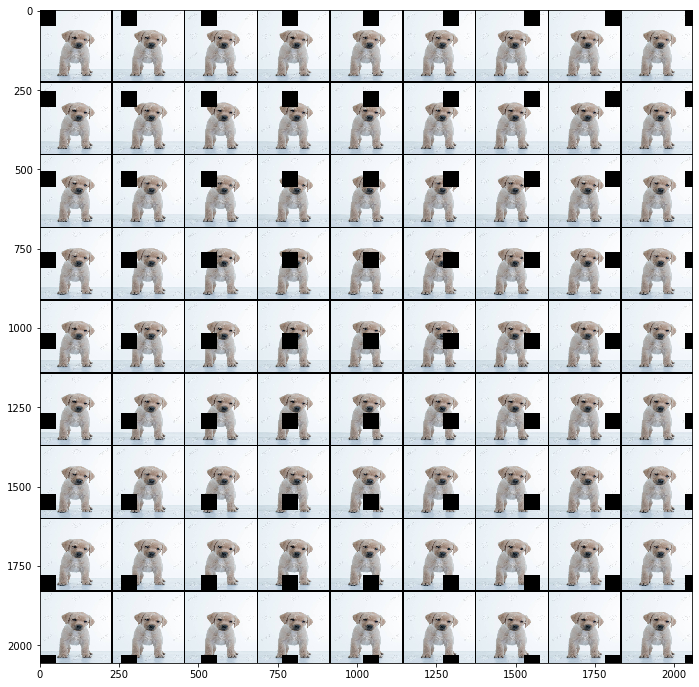

In [14]:
stitched_image = stitch_images(masked_images,cols=image_size[0])
plt.figure(figsize=(12,12))
plt.imshow(stitched_image)
plt.show()

In [15]:
def preprocess_image(img):
    img = tf.keras.applications.vgg16.preprocess_input(img.astype(np.float32))
    return np.expand_dims(img, axis=0)

In [16]:
scores = []
progbar = tf.keras.utils.Progbar(len(masked_images))
for i,img in enumerate(masked_images):
    img = preprocess_image(img)
    predictions = np.squeeze(model.predict(img))
    scores.append(predictions[np.argmax(predictions)])
    progbar.update(i+1)

81/81 [==============================] - 2s 19ms/step


In [17]:
scores = np.array(scores).reshape(image_size)

In [18]:
np.set_printoptions(linewidth=200)  # for printing numpy array properly
print(scores)
print(scores.shape)

[[0.9097047  0.9051872  0.89616334 0.87160254 0.8791073  0.9221093  0.9249209  0.9262297  0.90872544]
 [0.8983992  0.8720354  0.5158893  0.39974922 0.22891094 0.8154831  0.8294567  0.92177796 0.9013336 ]
 [0.8775042  0.7319762  0.4048972  0.13180362 0.16549395 0.5498306  0.7294271  0.877624   0.90617454]
 [0.8801407  0.82198775 0.41389778 0.34322873 0.1943589  0.3415013  0.7170758  0.84279054 0.8997928 ]
 [0.8903443  0.8233898  0.7268194  0.768045   0.5552025  0.6961165  0.7746659  0.90324354 0.89274997]
 [0.88914466 0.81675947 0.7812558  0.7272209  0.901803   0.76256096 0.89058393 0.8884818  0.8869494 ]
 [0.87987596 0.70946234 0.69802696 0.6612534  0.7825047  0.8762352  0.8944309  0.8770518  0.8846531 ]
 [0.8808822  0.78732276 0.8221612  0.7952566  0.88736415 0.8890724  0.9126795  0.89369184 0.8951241 ]
 [0.8929947  0.76394814 0.81748533 0.8320611  0.89311826 0.8881437  0.8786838  0.883456   0.8896489 ]]
(9, 9)


# Convert the scores to heatmap

In [19]:
heatmap = cv2.resize(scores, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)  # OpenCV is in BGR

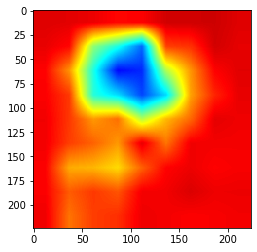

In [20]:
plt.imshow(heatmap)

In [21]:
def overlay(array1, array2, alpha=0.5):
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [22]:
superimposed_img = overlay(heatmap, image)

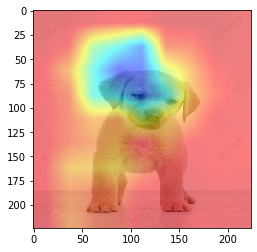

In [23]:
plt.imshow(superimposed_img)

# Results:

It is evident from the above example that, when we mask the labrador's face, the confidence score plummets(as expected) but, when we mask the other regions such as wall, labrador's legs, floor etc there isn't a noticable change in the predictions. This is reassuring as it indicates that the network is looking at the right part of the image to classify